In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import datetime, os
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from sklearn.model_selection import train_test_split
from skimage.io import imread
import os
from glob import glob
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.xception import preprocess_input as xception_preprocess_input

from tensorflow.keras.layers import GlobalMaxPooling2D, Dense,Flatten, Dropout
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras import Sequential , layers, models

from tensorflow.keras.models import Model

2024-08-23 10:58:02.159107: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-23 10:58:02.159232: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-23 10:58:02.281426: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
#loading dataframes
train_df = pd.read_csv('/kaggle/input/rsna-bone-age/boneage-training-dataset.csv')
test_df = pd.read_csv('/kaggle/input/rsna-bone-age/boneage-test-dataset.csv')


In [10]:
train_df.head()

,id,boneage,male
0,1377,180,False
1,1378,12,False
2,1379,94,False
3,1380,120,True
4,1381,82,False


Text(0.5, 1.0, 'Number of people in each age group')

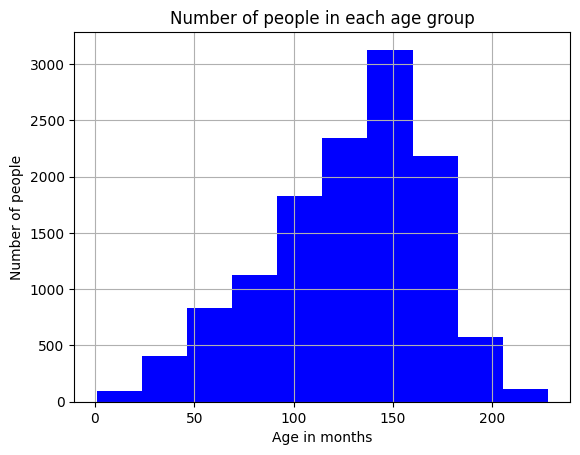

In [5]:
#plotting a histogram for bone ages
train_df['boneage'].hist(color = 'blue')
plt.xlabel('Age in months')
plt.ylabel('Number of people')
plt.title('Number of people in each age group')

In [6]:
test_df.head()


,Case ID,Sex
0,4360,M
1,4361,M
2,4362,M
3,4363,M
4,4364,M


In [7]:
train_df['id'] = train_df['id'].apply(lambda x: str(x) + '.png')
train_df.head()

,id,boneage,male
0,1377.png,180,False
1,1378.png,12,False
2,1379.png,94,False
3,1380.png,120,True
4,1381.png,82,False


In [8]:
test_df['Case ID'] = test_df['Case ID'].apply(lambda x: str(x) + '.png')
test_df.head()

,Case ID,Sex
0,4360.png,M
1,4361.png,M
2,4362.png,M
3,4363.png,M
4,4364.png,M


In [9]:
train_df['gender'] = train_df['male'].apply(lambda x: 'Male' if x == True else 'Female')
train_df.head()

,id,boneage,male,gender
0,1377.png,180,False,Female
1,1378.png,12,False,Female
2,1379.png,94,False,Female
3,1380.png,120,True,Male
4,1381.png,82,False,Female


gender
male      6833
female    5778
Name: count, dtype: int64


<Axes: xlabel='gender', ylabel='count'>

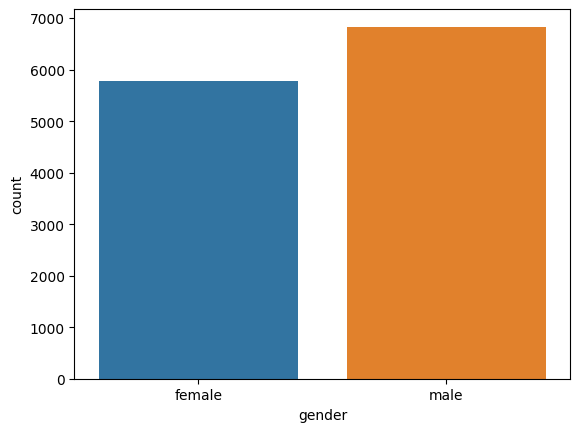

In [10]:
train_df['gender'] = train_df['male'].apply(lambda x: 'male' if x else 'female')
print(train_df['gender'].value_counts())
sns.countplot(x = train_df['gender'])

In [15]:
print('MAX age: ' + str(train_df['boneage'].max()) + ' months')

#youngest person in the dataset
print('MIN age: ' + str(train_df['boneage'].min()) + ' months')

#mean age is
mean_bone_age = train_df['boneage'].mean()
print('mean: ' + str(mean_bone_age))

#median bone age
print('median: ' +str(train_df['boneage'].median()))

#standard deviation of boneage
std_bone_age = train_df['boneage'].std()
print(std_bone_age)

MAX age: 228 months
MIN age: 1 months
mean: 127.3207517246848
median: 132.0
41.182021399396326


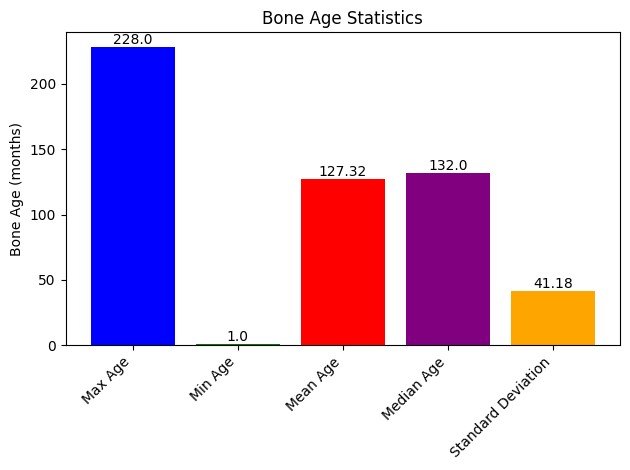

In [17]:


# Data
stats = {
    'Max Age': train_df['boneage'].max(),
    'Min Age': train_df['boneage'].min(),
    'Mean Age': train_df['boneage'].mean(),
    'Median Age': train_df['boneage'].median(),
    'Standard Deviation': train_df['boneage'].std()
}

# Plotting
fig, ax = plt.subplots()
bars = plt.bar(stats.keys(), stats.values(), color=['blue', 'green', 'red', 'purple', 'orange'])

# Adding value labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.ylabel('Bone Age (months)')
plt.title('Bone Age Statistics')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()


In [16]:

#models perform better when features are normalised to have zero mean and unity standard deviation
#using z score for the training
train_df['bone_age_z'] = (train_df['boneage'] - mean_bone_age)/(std_bone_age)

print(train_df.head())

         id  boneage   male  gender  bone_age_z
0  1377.png      180  False  Female    1.279181
1  1378.png       12  False  Female   -2.800269
2  1379.png       94  False  Female   -0.809109
3  1380.png      120   True    Male   -0.177766
4  1381.png       82  False  Female   -1.100498


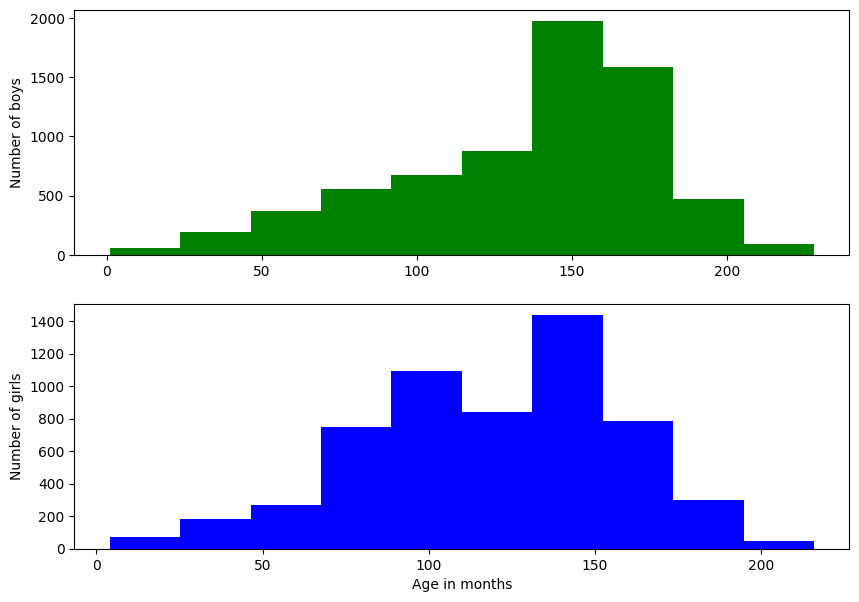

In [12]:
#distribution of age within each gender 

male = train_df[train_df['gender'] == 'male']
female = train_df[train_df['gender'] == 'female']
fig, ax = plt.subplots(2,1)
ax[0].hist(male['boneage'], color = 'green')
ax[0].set_ylabel('Number of boys')
ax[1].hist(female['boneage'], color = 'blue')
ax[1].set_xlabel('Age in months')
ax[1].set_ylabel('Number of girls')
fig.set_size_inches((10,7))

In [17]:
train_dir=('/kaggle/input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset/')
test_dir=('/kaggle/input/rsna-bone-age/boneage-test-dataset/')

In [18]:
df_train, df_valid = train_test_split(train_df, test_size = 0.25, random_state = 0)


In [19]:
# reducing  the size of the image
train_data_generator = ImageDataGenerator(preprocessing_function = xception_preprocess_input)
val_data_generator = ImageDataGenerator(preprocessing_function = xception_preprocess_input)


train_data = train_data_generator.flow_from_dataframe(
    dataframe = df_train,
    directory = train_dir,
    x_col= 'id',
    y_col= 'bone_age_z',
    batch_size = 32,
    seed = 42,
    shuffle = True,
    class_mode= 'other',
    flip_vertical = True,
    color_mode = 'rgb',
    target_size = (224, 224))


val_data = val_data_generator.flow_from_dataframe(
    dataframe = df_valid,
    directory = train_dir,
    x_col = 'id',
    y_col = 'bone_age_z',
    batch_size = 32,
    seed = 42,
    shuffle = True,
    class_mode = 'other',
    flip_vertical = True,
    color_mode = 'rgb',
    target_size = (224, 224))

test_data_generator = ImageDataGenerator(preprocessing_function = xception_preprocess_input)

test_data = test_data_generator.flow_from_directory(
    directory = test_dir,
    shuffle = True,
    class_mode = None,
    color_mode = 'rgb',
    target_size = (224,224))

Found 9458 validated image filenames.
Found 3153 validated image filenames.
Found 200 images belonging to 1 classes.


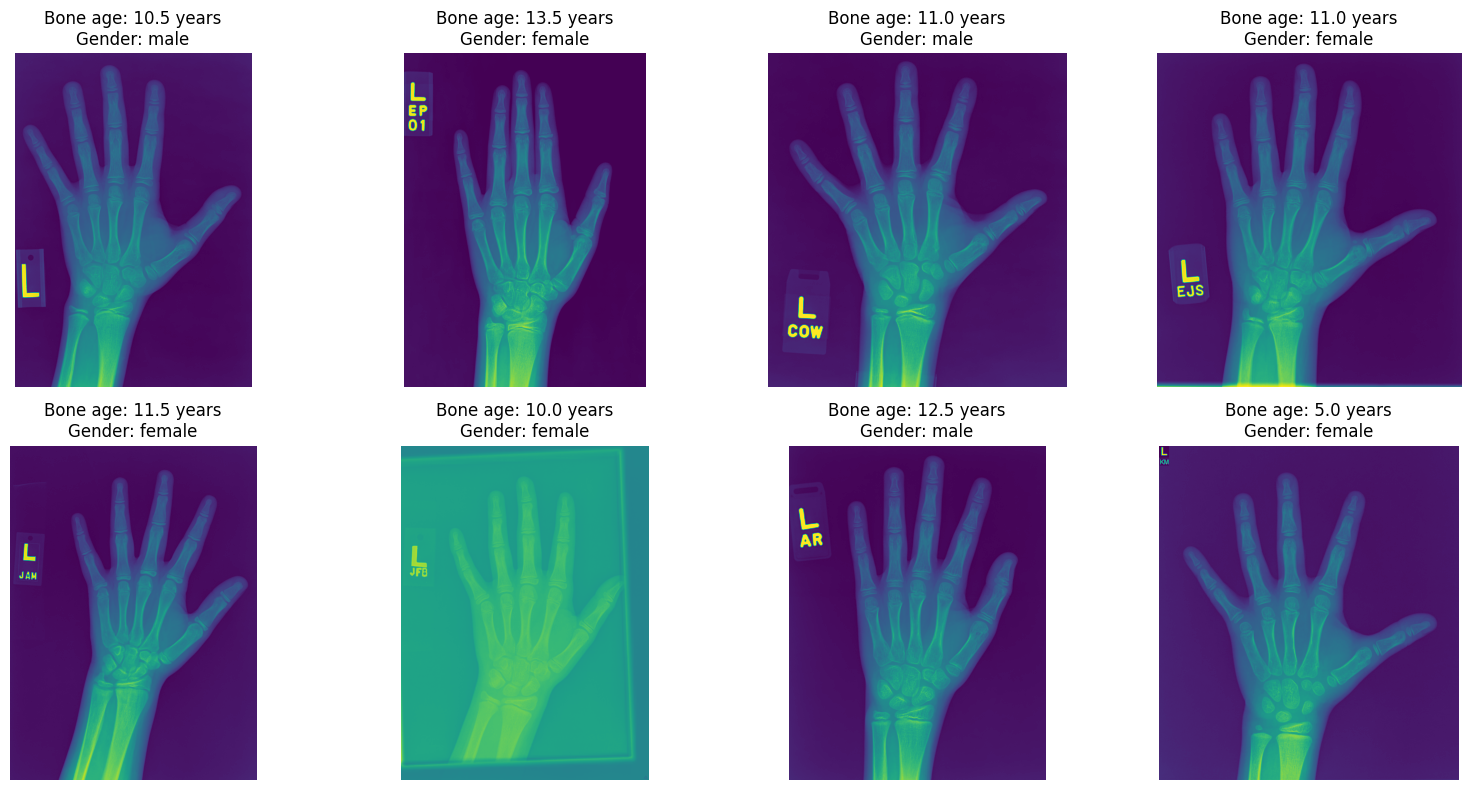

In [18]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Sample 8 images
sampled_df = train_df[['id', 'boneage', 'gender']].sample(8)

# Number of rows and columns
n_rows = 2
n_cols = 4

# Create a figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 8))

for i, (filename, boneage, gender) in enumerate(sampled_df.values):
    img = mpimg.imread('/kaggle/input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset/' + filename)
    ax = axes[i // n_cols, i % n_cols]
    ax.imshow(img)
    ax.set_title('Bone age: {} years\nGender: {}'.format(boneage / 12, gender))
    ax.axis('off')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [14]:

base_model = tf.keras.applications.Xception(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))

base_model.trainable = True

x = base_model.output
x = GlobalMaxPooling2D()(x)
x = Flatten()(x)
x = Dense(10, activation = 'relu')(x)
x = Dropout(0.2)(x)
output_layer = Dense(1, activation='linear')(x)

model = Model(inputs=base_model.input, outputs=output_layer)

 # Compiles the model for training.
model.compile(optimizer="adam",
                  loss="mse",
                  metrics= ["mae"] )

    

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [15]:

#early stopping
early_stopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience= 5,
                              verbose=0, mode='auto')

#model checkpoint
mc = ModelCheckpoint('best_model.keras', monitor='val_loss', mode='min', save_best_only=True)
#reduce lr on plateau
red_lr_plat = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

callback_list = [early_stopping,mc, red_lr_plat]

In [16]:
model_history = model.fit(train_data,
                            steps_per_epoch = 315,
                            validation_data = val_data,
                            validation_steps = 1,
                            epochs = 10,
                            callbacks= callback_list)
    


Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1724401121.487780     110 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1724401121.562351     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


155/315 ━━━━━━━━━━━━━━━━━━━━ 4:14 2s/step - loss: 0.8424 - mae: 0.7228

W0000 00:00:1724401366.905249     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


296/315 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - loss: 0.6890 - mae: 0.6406

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
W0000 00:00:1724401555.400556     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


315/315 ━━━━━━━━━━━━━━━━━━━━ 509s 1s/step - loss: 0.6760 - mae: 0.6333 - val_loss: 0.2067 - val_mae: 0.3707 - learning_rate: 0.0010
Epoch 2/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 285s 882ms/step - loss: 0.3275 - mae: 0.4173 - val_loss: 0.5433 - val_mae: 0.5164 - learning_rate: 0.0010
Epoch 3/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 289s 894ms/step - loss: 0.2790 - mae: 0.3701 - val_loss: 0.1957 - val_mae: 0.3537 - learning_rate: 0.0010
Epoch 4/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 288s 890ms/step - loss: 0.2785 - mae: 0.3628 - val_loss: 0.1246 - val_mae: 0.2895 - learning_rate: 0.0010
Epoch 5/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 287s 887ms/step - loss: 0.2600 - mae: 0.3398 - val_loss: 0.1445 - val_mae: 0.3224 - learning_rate: 0.0010
Epoch 6/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 287s 887ms/step - loss: 0.2498 - mae: 0.3157 - val_loss: 0.3043 - val_mae: 0.4675 - learning_rate: 0.0010
Epoch 7/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 291s 898ms/step - loss: 0.2447 - mae: 0.3151 - val_loss: 0.0813 - val_mae: 0.2213 - learning_rate:

In [19]:
test_X, test_Y = next(val_data_generator.flow_from_dataframe(
                            df_valid,
                            directory = train_dir,
                            x_col = 'id',
                            y_col = 'bone_age_z',
                            target_size = (224, 224),
                            batch_size = 3153,
                            class_mode="other",
                            ))

Found 3153 validated image filenames.


99/99 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step


/tmp/ipykernel_34/1111475676.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.set_title('Age: %fY\nPredicted Age: %fY' % (np.round(test_months[ind]/12.0),np.round(pred[ind]/12.0)))


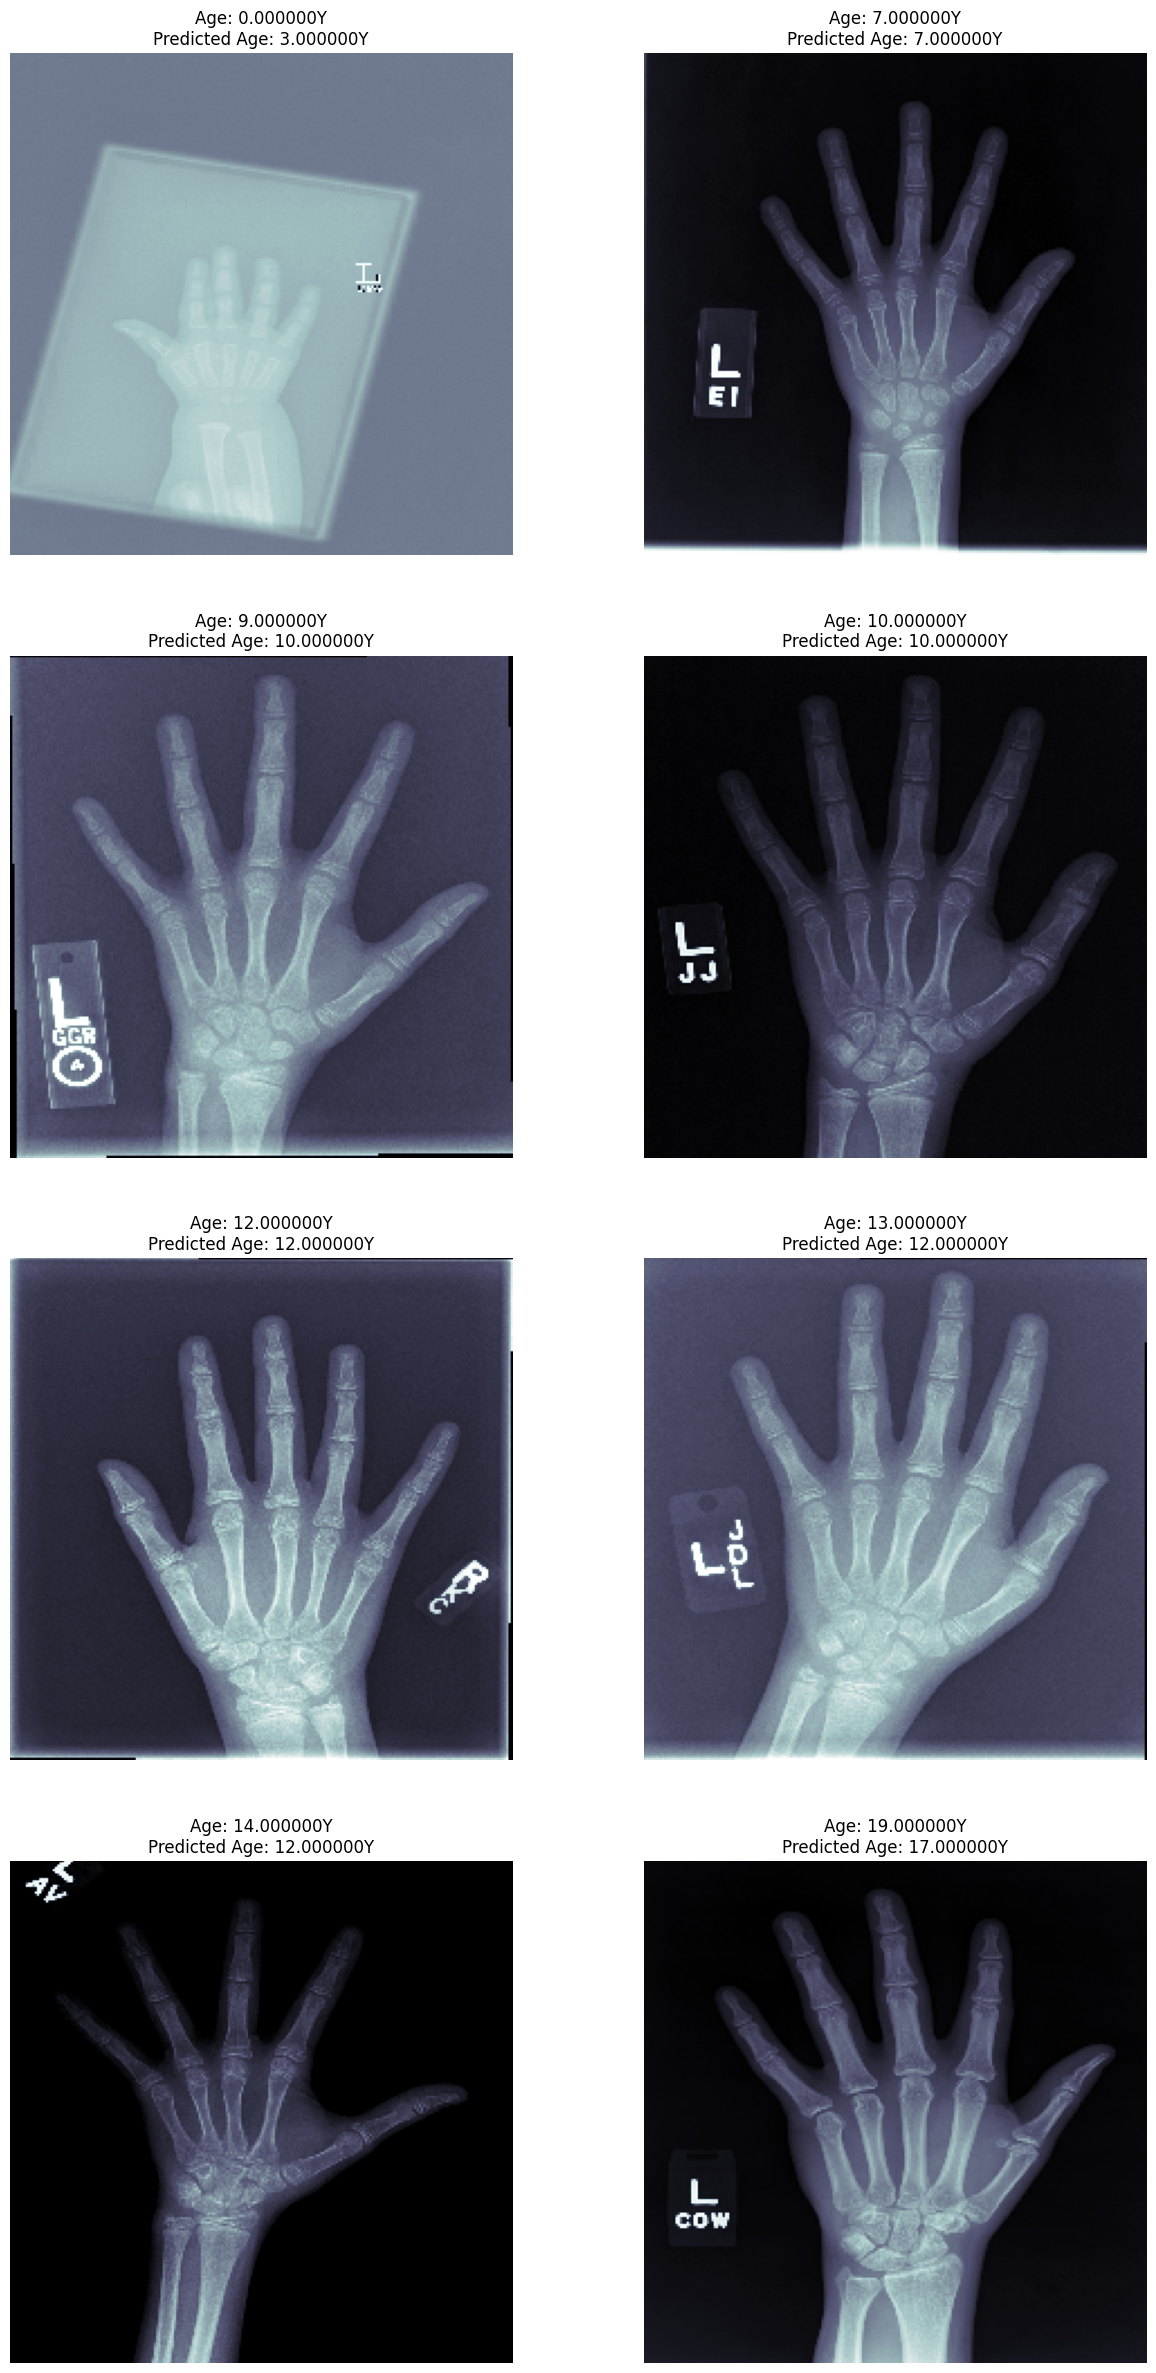

In [22]:
model.load_weights('best_model.keras')

pred = mean_bone_age + std_bone_age*(model.predict(test_X, batch_size = 32, verbose = True))

test_months = mean_bone_age + std_bone_age*(test_Y)

ord_ind = np.argsort(test_Y)
ord_ind = ord_ind[np.linspace(0, len(ord_ind)-1, 8).astype(int)] # take 8 evenly spaced ones

fig, axs = plt.subplots(4, 2, figsize = (15, 30))

for (ind, ax) in zip(ord_ind, axs.flatten()):
    ax.imshow(test_X[ind, :,:,0], cmap = 'bone')
    ax.set_title('Age: %fY\nPredicted Age: %fY' % (np.round(test_months[ind]/12.0),np.round(pred[ind]/12.0)))
    ax.axis('off')

fig.savefig('trained_image_predictions.png', dpi = 300)

In [ ]:
# pred = mean_bone_age + std_bone_age*(model.predict(test_data, batch_size = 64))
# ord_ind = np.argsort(test_data)
# ord_ind = ord_ind[np.linspace(0, len(ord_ind)-1,3 ).astype(int)]

# fig, axs = plt.subplots(4, 2, figsize = (15, 30))

# for (ind, ax) in zip(ord_ind, axs.flatten()):
#     ax.imshow(test_X[ind, :,:,0], cmap = 'bone')
#     ax.set_title('Age: %fY\nPredicted Age: %fY' % (pred[ind]/12.0))
#     ax.axis('off')



7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step


In [4]:
import tensorflow as tf

# Load the model
model = tf.keras.models.load_model('/kaggle/working/best_model.keras')

# Verify the model architecture
# model.summary()


In [20]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

def load_and_prep_image(filename, img_shape=224, rescale=True):
    img = image.load_img(filename, target_size=(img_shape, img_shape))
    img = image.img_to_array(img)
    
    if img.shape[-1] == 4:
        img = img[..., :3]
    
    if rescale:
        img = img / 255. 
    
    return img

def pred_and_plot(model, filename):
   
    img = load_and_prep_image(filename)

    # Make a prediction
    pred = model.predict(tf.expand_dims(img, axis=0))
    pred = mean_bone_age + std_bone_age * pred

    # Plot the image and the prediction
    plt.imshow(img)
    plt.title(f'Predicted Bone Age: {np.round(pred[0][0]/12.0)} years')
    plt.axis('off')
    plt.show()

# Example usage:
# pred_and_plot(model, "/kaggle/input/bone-image/bone image.png", mean_bone_age, std_bone_age)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


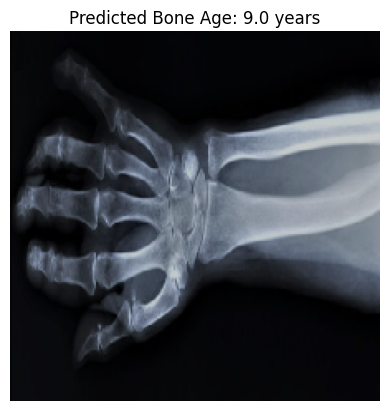

In [21]:
filename = "/kaggle/input/bone-image/bone image.png"

pred_and_plot(model,filename)